In [70]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 27 11:19:07 2020

@author: Max J. de Bock
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import make_interp_spline, BSpline
import numpy.polynomial.polynomial as poly
import statistics as stat
from scipy.signal import find_peaks
from scipy.stats import norm, jarque_bera
from scipy.fft import fft, ifft
from sympy.integrals.transforms import laplace_transform
from scipy.fftpack import fftshift
import scipy as sc

In [7]:
df = pd.DataFrame({'Series': [np.nan], 'Epsilon': [np.nan], 'Sd': [np.nan]}).dropna()
def LoadData():
    SP = pd.read_csv('^GSPC.csv')
    return SP

# White noise 

In [8]:
def WhiteNoise(df,mean,sd):
    n = 100
    for i in range(n):
        Xt = np.random.normal(mean,sd)
        df = df.append({'Series': Xt}, ignore_index=True)
    plt.scatter(np.linspace(1,n,n),df['Series'])
    return

# Qth-Order Moving Average:

In [9]:
def QthMovAve(df,mean,sd,order):
    weights = np.linspace(1,order,order)
    weights = weights/np.sum(weights)
    n = 1000
    for i in range(n):
        epsilon = np.random.normal(0,sd)
        Xt = mean
        if i != 0:
            for j in range(np.minimum(i,order-1)):    
                 Xt += weights[order-j-1]*df['Epsilon'].iloc[i-j-1]
        df = df.append({'Series': Xt, 'Epsilon': epsilon}, ignore_index=True)
    print(df)
    plt.scatter(np.linspace(1,n,n),df['Series'])
    return

In [10]:
def SquaredErrorforCycleLength(A,length):
    A = np.array(A)
    var_list = np.zeros(length)
    n = len(A)
    for i in range(length):
        k = 0
        point_list = []
        while k*length <= n-1:
            point_list.append(A[k*length])
            k += 1
        var_list[i] = stat.variance(point_list)
    return stat.mean(var_list)

Thing that tries to find period of periodic function:

In [11]:
def CycleLength(A):
    A = np.array(A)
    SquaredErrors = np.zeros(int(len(A)*2/3))
    for length in range(1,int(len(A)*2/3)):
        SquaredErrors[length] = SquaredErrorforCycleLength(A, length)
    return SquaredErrors

# Qth-Order Auto-regressive:

In [12]:
def QthAR(df,sd,order):
    weights = np.linspace(1,order,order)
    weights = weights/np.sum(weights)
    n = 100
    for i in range(n):
        epsilon = np.random.normal(0,sd)
        Xt = epsilon
        if i != 0:
            for j in range(np.minimum(i,order)):
                Xt += weights[order-j-1]*df['Series'].iloc[i-j-1]
        df = df.append({'Series': Xt}, ignore_index=True)
    plt.scatter(np.linspace(1,n,n),df['Series'])
    return

# Qth-order Auto-regressive conditional heteroskedasticity (ARCH):

In [73]:
def QArch(df,a,order,n):
    #Choosing the weights of the model (assuming weakly-stationary covariance)
    weights = np.linspace(1,order,order)
    weights = (200)**(weights/order)
    weights = weights/np.sum(weights)
    for i in range(n):
        #This is that first term constant
        sd = a
        for j in range(np.minimum(i,order+1)):
            #Summing the products of the weights and squares of previous datapoints
            sd += weights[order-j-1]*df['Series'].iloc[i-j-1]*df['Series'].iloc[i-j-1]
        #Generating next datapoint
        Xt = np.random.normal(0,sd)
        df = df.append({'Series': Xt, 'Sd': sd}, ignore_index=True)
    #Just formatting
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle('ARCH(%d)' % order)
    lin = np.linspace(1,n,n)
    ax1.bar(lin,df['Series'])
    ax2.bar(lin,df['Sd'])
    #Getting an approximating poly through it uses Gaussian quadrature,
    #so it is going to be exact up to n/2. This is why I picked n/10.
    #This is really just a randomly chosen number, but line looks 'eye-ball' representative for smoothness = 10 if n = 1000.
    #EDIT: The smoothness of the line will be will change the scale that the red line represents, meaning the period of 
    #the line will be very clearly altered by this!!!
    smoothness = 10
    degree = int(np.ceil(n/smoothness))
    xnew = np.linspace(1,n, n*10) 
    coefs = poly.polyfit(lin, df['Sd'], degree)
    ffit = poly.polyval(xnew, coefs)
    plt.plot(xnew, ffit, 'r')
    # #More formatting
    low = min(df['Sd'])
    high = max(df['Sd'])
    plt.ylim([low,high])
    ax3 = ax2.twinx()
    cycle_length = CycleLength(ffit[1::10])
    
    l = len(cycle_length)
    ax3.plot(np.linspace(1,l,l),cycle_length)
    slicing = 50
    ax3.plot(np.linspace(1+int(slicing/10),n-int(slicing/10),n*10-2*slicing),abs(fft(ffit[slicing:len(ffit)-slicing])))
    plt.ylim([0,0.2])
    fig.tight_layout()
    plt.show()
    
    
    return find_peaks(cycle_length, \
                      #threshold = (max(cycle_length)-min(cycle_length))/40),\
                      width = 10),\
           #ChangePlot(df['Series'])

C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\polynomial\polyutils.py:706: RuntimeWarning: overflow encountered in square
  scl = np.sqrt(np.square(lhs).sum(1))
C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\polynomial\polynomial.py:1336: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


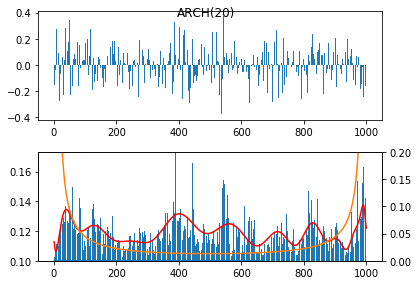

((array([ 18, 198, 277, 388, 560, 650], dtype=int64),
  {'prominences': array([4.04919694e-06, 1.09990771e-04, 4.56655635e-05, 1.14081923e-04,
          5.75084813e-05, 2.25257478e-06]),
   'left_bases': array([  0,   0, 250, 334, 500, 627], dtype=int64),
   'right_bases': array([ 20, 316, 316, 477, 627, 665], dtype=int64),
   'widths': array([18.49691911, 27.61478296, 18.12806073, 55.31040648, 56.28856851,
          19.76096452]),
   'width_heights': array([4.16879285e-05, 5.61731590e-05, 3.05400603e-05, 6.73535567e-05,
          4.71439315e-05, 2.08627697e-06]),
   'left_ips': array([  0.98356265, 185.727421  , 269.14340458, 371.68157073,
          530.11453092, 639.85333675]),
   'right_ips': array([ 19.48048176, 213.34220396, 287.27146531, 426.99197722,
          586.40309942, 659.61430128])}),)

In [74]:
#To get decent compromise between data and run-time I went for QArch(df,0.1,20,1000)
QArch(df,0.1,20,1000)

# Daily-changes hist, fitting Gauss distr and JB-test:

In [15]:
def ChangePlot(A):
    if len(A.shape) == 2:
        Change = A['Close']-A['Open']
    else:
        Change = A
    plt.hist(Change, bins=100, density = True)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    mu, std = norm.fit(Change)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.show()
    
    fig, (ax1, ax2) = plt.subplots(2, 1)
    l = len(Change)
    lin = np.linspace(1,l,l)
    SqrChange = Change*Change
    
    ax1.bar(lin,Change)
    ax2.bar(lin,SqrChange)

    smoothness = 30
    degree = int(np.ceil(l/smoothness))
    xnew = np.linspace(1,l, l*smoothness) 
    coefs = poly.polyfit(lin, SqrChange, degree)
    ffit = poly.polyval(xnew, coefs)
    plt.plot(xnew, ffit, 'r')
    # #More formatting
    low = min(SqrChange)
    high = max(SqrChange)
    plt.ylim([low,high])
    
    plt.bar(lin,Change)
    
    plt.bar(lin,SqrChange)
    return jarque_bera(Change)
    

Here S&P 500 data is used:

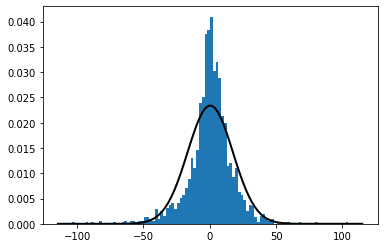

C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\polynomial\polyutils.py:706: RuntimeWarning: overflow encountered in square
  scl = np.sqrt(np.square(lhs).sum(1))
C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\polynomial\polynomial.py:1336: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


(1640.4551784222106, 0.0)

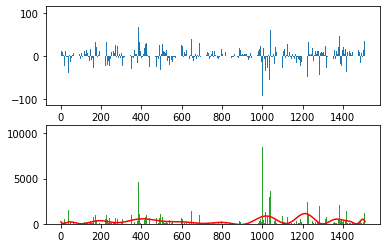

In [16]:
sp = LoadData()
ChangePlot(sp)